# FEM-FDM comparison

This notebook contains an animated graph showing the convergence of the finite
difference method (FDM) to the finite element method (FEM). With the problem
at hand, whereas the latter relies in the inversion of the stiffness matrix
$\mathbf{K}$, the former converges towards the result through a iterative scheme.

## FD method
Considering the static problem in the one dimensional case, one has 

$$
    -\mu \partial_x^2u(x) = f(x)\,,
$$
where the $\mu$ is the shear modulus, $u$ is the stress amplitude and $f$
is the force. Using a $3-$point operator for the second derivative, the element
$u_i$ is obtained as

$$
    u_{i} = \frac{dx^2}{2\mu}f_i + \frac{u_{i+1} + u_{i-1}}{2}\,,
$$
where we are supposing a constant displacement $dx$. As pointed
out by professor Igel, the stress amplitude at a given point is obtained
by the force at that point plus the influence of its first neighbours.

## FE method

We have obtained for the finite element method the equation $\mathbf{K^\mathrm{T}}\cdot\mathbf{u} = \mathbf{f}$.
Inverting it one readly obtains the amplitudes

$$
    \mathbf{u} = \left(\mathbf{K^\mathrm{T}}\right)^{-1}\cdot\mathbf{f}\,,
$$

Now we make the python code for the comparison between the two methods

In [5]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

nx = 30            # number of gridpoints
xmin = 0
xmax = 5
dx = (xmax-xmin)/nx # spatial step
x = np.linspace(xmin,xmax, nx)

mu = 1              # shear modulus

u = np.zeros(nx)    # initializing the amplitude vector
f = np.zeros(nx)    # initializing the force vector

K = np.zeros((nx,nx))

for i in range(0,nx):
    for j in range(0,nx):
        if j == i:
            K[i, j] = 2
        elif j == i + 1 or j == i-1:
            K[i, j] = -1
        else:
            K[i, j] = 0

K[0,0] = K[nx-1,nx-1] = 1 # fixing the elements K_11 and K_nmax,nmax

K = K*mu/dx               # including the multiplicative factor


print ('The determinant of the stiffness matrix is det(K)=', np.linalg.det(K))

The determinant of the stiffness matrix is det(K)= 0.0


However, this method can not be employed rightaway, since it has a zero mode,
*i.e.,* it has an eigenvalue zero, which must be singled out. From a linear
algebra point of view, it cannot be inverted because since the boundary condition
was not specified an infinity number of solutions are possible. Therefore,
we need to include the boundary condition to make it possible to solve.
Since we already known the values at the boundaries, *i.e.*, $u_1$ and
$u_N$, we need to only find the values of the matrix element in between
these points. Consequently, we observe that we only need to consider
the elements between $i=2$ up to element $i=N-1$.

In [6]:
## BOUNDARY CONDITION ##
u1 = 0.15
uN = 0.05

f[int(3.*nx/4)] = 1

f_r = f - u1*K[0, :] - uN*K[nx-1, :] # force rescaled by the boundary condition

u[1:nx-1] = np.dot(np.linalg.inv(K[1: nx-1, 1: nx-1]), f_r[1:nx-1])    # force within the bulk (finite element method solution)
u[0] = u1                                                              # boundary condition 1
u[-1] = uN                                                             # boundary condition 2

$$
    u_{i} = \frac{dx^2}{2\mu}f_i + \frac{u_{i+1} + u_{i-1}}{2}\,,
$$

<IPython.core.display.Javascript object>


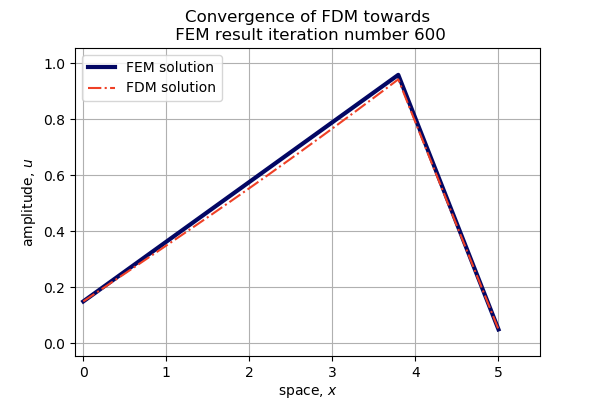

In [7]:
## FINITE DIFFERENCE SOLUTION ##

it = 603

u_fd = np.zeros(nx)
alpha = dx**2/(2*mu)

u_fd[0] = u1
u_fd[-1] = uN

## PLOTTING SECTION ##

fig, ax = plt.subplots(figsize = (6,4))
ax.set_xlabel('space, $x$')
ax.set_ylabel('amplitude, $u$')
ax.set_xlim(-.1,1.1*xmax)
ax.set_ylim(-0.9*np.min(u), 1.1*np.max(u))
ax.set_title('Convergence of FDM towards\n FEM result iteration it = 0')
ax.grid(True)

line_fem, = ax.plot(x, u, color = 'xkcd:darkblue', label = 'FEM solution', lw = 3)
line_fdm, = ax.plot(x, u_fd, color = 'xkcd:tomato', ls = '-.', label = 'FDM solution')

ax.legend()

du = np.zeros(nx)

for i in range(it):
    for j in range(1,nx-1):
        du[j] = u_fd[j+1] + u_fd[j-1]
    u_fd[1:-1] = alpha*f[1:-1]/dx + du[1:-1]/2
    if i%3 == 0:
        line_fdm.set_ydata(u_fd)
        ax.set_title('Convergence of FDM towards\n FEM result iteration number %.f'%i)
        plt.gcf().canvas.draw()